To use C++ code in python, we have to build a class in C++ and then export it as a library that python can read. [This](https://www.auctoris.co.uk/2017/04/29/calling-c-classes-from-python-with-ctypes/) article makes that library.so and then uses ctypes when calling the class and passing it variables in python. [This](https://iq.opengenus.org/create-shared-library-in-cpp/) article has an alternate way of creating the library that is much simpler.

The way I structures this notebook to do soccer analysis is to write the file in a code cell here, then import it from the following code cell (stored in Drive). The class takes in 4 variables upon creation: home and away team atk and def ratings. Upon construction, the class calculates home and away win percentages, which can each be returned with a function call.

To test this, I can use values from the World Cup simulator, which will make the declarations in python trivial and avoid a significant amount of data manipulation.

In [ ]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

In [ ]:
%%writefile CalcWinPercentage.cpp

#include <iostream>
#include <cstring>
#include <cstdlib>
#include <string>
#include <cmath>

using namespace std;

class CalcWinPercentage {
    public:
        CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void calc(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void reset() {
            homewin = 0.0;
            awaywin = 0.0;
        }
        double homewinpercentage() {return homewin;}
        double awaywinpercentage() {return awaywin;}
        int factorial (int num);
        
        const float avgGoals = 1.56;
 
    private:
        double homewin, awaywin;
};

CalcWinPercentage::CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    homewin = 0;
    awaywin = 0;

    int i, j;
    float scoreChance, homeExpGoals, awayExpGoals;
 
    // this is broken because the formula is based on percentages, so 1 - x is positive
    homeExpGoals = ((homeAtk * awayDef) / avgGoals) / ((homeAtk * awayDef) / avgGoals + (avgGoals/ (homeAtk * awayDef)));
    awayExpGoals = ((awayAtk * homeDef) / avgGoals) / ((awayAtk * homeDef) / avgGoals + ((1 - awayAtk) * (1 - homeDef) / (1 - avgGoals)));
 
    for (i = 0; i < 8; i++) {
        for (j = 0; j < 8; j++) {
            scoreChance = pow(homeExpGoals, i) * pow(awayExpGoals, j) * exp(-(homeExpGoals + awayExpGoals)) / (factorial(i) * factorial(j));
            if (i > j) {
                homewin += scoreChance;
            }
            if (j > i) {
                awaywin += scoreChance;
            }
        }
    }

    homewin = homeExpGoals;
    awaywin = awayExpGoals;
}

void CalcWinPercentage::calc(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    int i, j;
    float scoreChance;
    homewin = 0;
    awaywin = 4.5;
 
}

int CalcWinPercentage::factorial (int num) {
    int result = 1;
    if (num > 0) {
        for (int i = num; i > 1; i--) {
            result *= i;
        }
    }
    return result;
}

// Define C functions for the C++ class that can be accessed by ctypes

extern "C"
{
    CalcWinPercentage* CWP_new(double ha, double hd, double aa, double ad) {return new CalcWinPercentage(ha, hd, aa, ad);}
    void CWP_calc(CalcWinPercentage* cwp, double ha, double hd, double aa, double ad) {cwp->calc(ha, hd, aa, ad);}
    void CWP_reset(CalcWinPercentage* cwp) {cwp->reset();}
    double CWP_homewinpercentage(CalcWinPercentage* cwp) {return cwp->homewinpercentage();}
    double CWP_awaywinpercentage(CalcWinPercentage* cwp) {return cwp->awaywinpercentage();}
    int CWP_factorial(CalcWinPercentage* cwp, int num) {return cwp->factorial(num);}
}

Writing CalcWinPercentage.cpp


In [ ]:
!rm libCalcWinPercentage.so
!rm CalcWinPercentage.o
!ls -l

rm: cannot remove 'libCalcWinPercentage.so': No such file or directory
rm: cannot remove 'CalcWinPercentage.o': No such file or directory
total 12
-rw-r--r-- 1 root root 2649 Jul 10 03:14 CalcWinPercentage.cpp
drwx------ 5 root root 4096 Jul 10 03:08 drive
drwxr-xr-x 1 root root 4096 Jul  6 13:22 sample_data


In [ ]:
!g++ -c -fPIC CalcWinPercentage.cpp -o CalcWinPercentage.o
!gcc -shared -o libCalcWinPercentage.so CalcWinPercentage.o
!ls -l

total 36
-rw-r--r-- 1 root root  2660 Jul 20 01:18 CalcWinPercentage.cpp
-rw-r--r-- 1 root root  7952 Jul 20 01:19 CalcWinPercentage.o
drwx------ 5 root root  4096 Jul 20 01:18 drive
-rwxr-xr-x 1 root root 13608 Jul 20 01:19 libCalcWinPercentage.so
drwxr-xr-x 1 root root  4096 Jul 13 13:43 sample_data


In [ ]:
import ctypes
import numpy as np
import pandas as pd

lib = ctypes.cdll.LoadLibrary('/content/libCalcWinPercentage.so')

class CalcWinPercentage:
  def __init__(self, ha, hd, aa, ad):
    lib.CWP_new.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_new.restype = ctypes.c_void_p

    lib.CWP_calc.argtypes = [ctypes.c_void_p, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_calc.restype = ctypes.c_void_p

    lib.CWP_reset.argtypes = [ctypes.c_void_p]
    lib.CWP_reset.restype = ctypes.c_void_p

    lib.CWP_homewinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_homewinpercentage.restype = ctypes.c_double

    lib.CWP_awaywinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_awaywinpercentage.restype = ctypes.c_double

    lib.CWP_factorial.argtypes = [ctypes.c_void_p, ctypes.c_int]
    lib.CWP_factorial.restype = ctypes.c_int

    self.obj = lib.CWP_new(ha, hd, aa, ad)

  def calc(self, ha, hd, aa, ad):
    lib.CWP_calc(self.obj, ha, hd, aa, ad)

  def reset(self):
    lib.CWP_reset(self.obj)

  def homewinpercentage(self):
    return lib.CWP_homewinpercentage(self.obj)

  def awaywinpercentage(self):
    return lib.CWP_awaywinpercentage(self.obj)

# from lib import CalcWinPercentage

# Test that the C++ library is working

cwp = CalcWinPercentage(4, 5, 6.7, 7)
print(cwp.awaywinpercentage())
print(cwp.homewinpercentage())
cwp.reset()
print(cwp.awaywinpercentage())

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors



# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

EPL_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2021 2022.csv')
EPL_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2020 2021.csv')
EPL_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2019 2020.csv')
EPL_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2018 2019.csv')
EPL_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2017 2018.csv')
EPL_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/EPL Betting Odds 2016 2017.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
EPL_match_odds = EPL_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
EPL_match_odds['B365A'] = EPL_match_odds['B365A'].apply(lambda x: 1/x)
EPL_match_odds['B365D'] = EPL_match_odds['B365D'].apply(lambda x: 1/x)
EPL_match_odds['B365H'] = EPL_match_odds['B365H'].apply(lambda x: 1/x)

spi_matches_EPL = spi_matches[spi_matches['league'] == 'Barclays Premier League']
spi_matches_EPL = spi_matches_EPL.replace(to_replace='AFC Bournemouth', value='Bournemouth').sort_values(['season', 'team1', 'team2'])

# This block will load the data I'm using into a new dataframe to make it easier to manipulate
# The odds in the odds_comparison dataframe represent the difference between SPI match
# probability and the line offered at Bet365. Positive numbers represent +EV
home_odds = np.array(spi_matches_EPL['prob1']) - np.array(EPL_match_odds['B365H'])
home_odds = [round(x*100, 2) for x in home_odds]

away_odds = np.array(spi_matches_EPL['prob2']) - np.array(EPL_match_odds['B365A'])
away_odds = [round(x*100, 2) for x in away_odds]

draw_odds = np.array(spi_matches_EPL['probtie']) - np.array(EPL_match_odds['B365D'])
draw_odds = [round(x*100, 2) for x in draw_odds]

odds_comparison = pd.DataFrame({'Season': spi_matches_EPL['season'],
                                'Home Team': spi_matches_EPL['team1'],
                                'Away Team': spi_matches_EPL['team2'],
                                'Home Edge': home_odds,
                                'Away Edge': away_odds,
                                'Draw Edge': draw_odds,
                                'Result': np.array(EPL_match_odds['FTR'])})

# Arrays to build the game_data DataFrame
season = [np.array(spi_matches_EPL['season'])[x+10] for x in range(len(spi_matches_EPL) -10)]
date = [np.array(spi_matches_EPL['date'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
hometeam = [np.array(spi_matches_EPL['team1'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
home_goals = [np.array(spi_matches_EPL['xg1'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
away_goals = [np.array(spi_matches_EPL['xg2'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
awayteam = [np.array(spi_matches_EPL['team2'])[x+10] for x in range(len(spi_matches_EPL) - 10)]
result = [np.array(EPL_match_odds['FTR'])[x+10] for x in range(len(EPL_match_odds) - 10)]
home_odds = [np.array(EPL_match_odds['B365H'])[x+10] for x in range(len(EPL_match_odds) - 10)]
away_odds = [np.array(EPL_match_odds['B365A'])[x+10] for x in range(len(EPL_match_odds) - 10)]
draw_odds = [np.array(EPL_match_odds['B365D'])[x+10] for x in range(len(EPL_match_odds) - 10)]
pythag = np.divide(np.multiply(home_goals, home_goals), np.add(np.multiply(home_goals, home_goals), np.multiply(away_goals, away_goals)))

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_EPL is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

lg_avg_home = spi_matches_EPL['xg1'].sum()/len(spi_matches_EPL)
lg_avg_away = spi_matches_EPL['xg2'].sum()/len(spi_matches_EPL)

game_data = pd.DataFrame({'Season': np.array(season),
                          'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals),
                          'Goal Difference': np.array(home_goals) - np.array(away_goals),
                          'Pythag': np.array(pythag),
                          'Result': np.array(result),
                          'Home Odds': np.array(home_odds),
                          'Away Odds': np.array(away_odds),
                          'Draw Odds': np.array(draw_odds)})

# This slice creates a sample that can be used to generate better atk/def ratings
# Keep in mind that this extra data used to create ratings does not apply to promoted teams
game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_EPL) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
game_data = game_data.dropna()
game_data = game_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

sample_data = game_data[game_data['Season'] < 2021]
test_data = game_data[game_data['Season'] >= 2021].reset_index(drop=True)
sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]

gld_home = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_away = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_home.fit(sample_home, np.array(sample_data['Home Goals']))
gld_away.fit(sample_away, np.array(sample_data['Away Goals']))

pred_home = [[test_data['Home Atk'][x], test_data['Away Def'][x]] for x in range(len(test_data))]
pred_away = [[test_data['Away Atk'][x], test_data['Home Def'][x]] for x in range(len(test_data))]
model_xg_home = gld_home.predict(pred_home)
model_xg_away = gld_away.predict(pred_away)
             
test_data['Gamma Pred Home'] = np.array(model_xg_home)
test_data['Gamma Pred Away'] = np.array(model_xg_away)
test_data['Gamma Pred Pythag'] = np.divide(np.multiply(model_xg_home, model_xg_home), np.add(np.multiply(model_xg_home, model_xg_home), np.multiply(model_xg_away, model_xg_away)))

print("\n", "Gamma distribution predictions")
print(test_data['Gamma Pred Home'].corr(test_data['Home Goals']))
print(test_data['Gamma Pred Away'].corr(test_data['Away Goals']))

print("\n", "SPI correlation")
print(spi_matches_EPL['proj_score1'].corr(spi_matches_EPL['xg1']))
print(spi_matches_EPL['proj_score2'].corr(spi_matches_EPL['xg2']))

print("\n", "League Average Goals Scored")
print(lg_avg_home)
print(lg_avg_away)



 Gamma distribution predictions
0.5292342673114441
0.5173170360449282

 SPI correlation
0.5194970903626085
0.498573500172721

 League Average Goals Scored
1.564592105263158
1.283565789473684


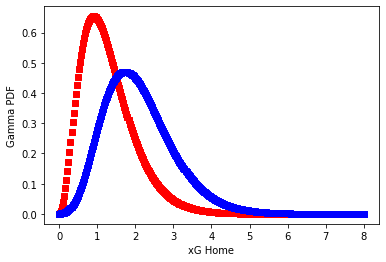

Season                               2021
Date                           2022-03-12
Home Team        Brighton and Hove Albion
Away Team                       Liverpool
Home Goals                           0.69
Away Goals                            2.5
Home Atk                          1.46225
Home Def                           0.9285
Away Atk                            2.489
Away Def                             1.27
Model xG Home                      1.2796
Model xG Away                      2.0822
Name: 65, dtype: object


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

y = 65
buckets = np.linspace(0, 8, num=300)
pdf_buckets_home = [gamma.pdf(buckets[x], constraints_home[y][0], constraints_home[y][1], constraints_home[y][2]) for x in range(len(buckets))]
pdf_buckets_away = [gamma.pdf(buckets[x], constraints_away[y][0], constraints_away[y][1], constraints_away[y][2]) for x in range(len(buckets))]
plt.scatter(buckets, pdf_buckets_home, c='red', marker='s')
plt.scatter(buckets, pdf_buckets_away, c='blue', marker='s')
plt.xlabel('xG Home')
plt.ylabel('Gamma PDF')
plt.show()
disp_cols = ['Season', 'Date', 'Home Team', 'Away Team', 'Home Goals', 'Away Goals', 'Home Atk', 'Home Def', 'Away Atk', 'Away Def', 'Model xG Home', 'Model xG Away']
print(test_data[disp_cols].iloc[y])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
import scipy.integrate as integrate

def CalcIntegral(a, b, constraints_home, constraints_away):
  mean = (a + b) / 2
  result_home = integrate.quad(lambda x: gamma.pdf(x, constraints_home[0], loc=constraints_home[1], scale=constraints_home[2]), a, b)
  result_away = integrate.quad(lambda x: gamma.pdf(x, constraints_away[0], loc=constraints_away[1], scale=constraints_away[2]), a, b)
  return [mean, result_home[0], result_away[0]]

n = 1000
a = np.linspace(0, 8, num=n)
result = []

for i in range(n-1):
  result.append(CalcIntegral(a[i], (a[i+1]), constraints_home[y], constraints_away[y]))

home_odds = 0
away_odds = 0
draw_odds = 0

for i in range(n-1):
  for j in range(n-1):
    if (result[i][0] > (result[j][0] + .5)):
      home_odds += (result[i][1] * result[j][2])
    elif (result[j][0] > (result[i][0] + .5)):
      away_odds += (result[i][1] * result[j][2])
    else:
      draw_odds += (result[i][1] * result[j][2])

print(home_odds)
print(away_odds)
print(draw_odds)
print(spi_matches_EPL.loc[spi_matches_EPL['date'] == test_data['Date'].iloc[y], ['team1', 'team2', 'prob1', 'prob2', 'probtie']])

0.11610836981089523
0.6015890169414047
0.28226492862957087
0.9999623153818707
                          team1              team2   prob1   prob2  probtie
52481                 Brentford            Burnley  0.4135  0.3016   0.2849
52453  Brighton and Hove Albion          Liverpool  0.1350  0.6670   0.1980
52526         Manchester United  Tottenham Hotspur  0.3876  0.3693   0.2432
